# This file computes diagonalisation & pre-computes results for use later

## Import appropriate modules

In [165]:
import numpy as np
from numpy.linalg import eigh
from numpy import save, savez, savez_compressed
import ast

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import *

from tqdm import tqdm
from numba import jit

import scipy.constants

In [166]:
import matplotlib.pyplot as plt
# plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
# plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}\usepackage{mathtools}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

## Defining parameters

In [167]:
MOLECULE_STRING = "Rb87Cs133"
MOLECULE = Rb87Cs133
N_MAX=2
# PULSE_TIME_US = 500 #μs

GAUSS = 1e-4 # T
B = np.concatenate([np.arange(0.1,100,0.1),np.arange(100,500,1),np.arange(500,1000,10)]) * GAUSS

######

B_STEPS = len(B)
B_MIN = B[0]
B_MAX= B[-1]

settings_string = f'{MOLECULE_STRING}NMax{N_MAX}'

H_BAR = scipy.constants.hbar

I1 = MOLECULE["I1"]
I2 = MOLECULE["I2"]
I1_D = round(2*MOLECULE["I1"])
I2_D = round(2*MOLECULE["I2"])

PER_MN = (I1_D+1)*(I2_D+1)
N_STATES = PER_MN * (N_MAX+1)**2

# PULSE_TIME = PULSE_TIME_US * 1e-6 # s

# Generate canonical label & sparse edge ordering

In [168]:
def label_degeneracy(N,MF_D):
    # Want number of ways of having
    # MF = MN + (M_I1 + M_I2) # NP-Hard Problem SSP (Subset Sum)
    d=0
    for MN in range(-N,N+1):
        for M_I1_D in range(-I1_D,I1_D+1,2):
            for M_I2_D in range(-I2_D,I2_D+1,2):
                if 2*MN+M_I1_D+M_I2_D == MF_D:
                    d+=1
    return d

In [169]:
UNCOUPLED_LABELS_D = []

for n in range(0, N_MAX + 1):
    for mn in range(n,-(n+1),-1):
        for mi1d in range(I1_D,-I1_D-1,-2):
            for mi2d in range(I2_D,-I2_D-1,-2):
                UNCOUPLED_LABELS_D.append((n,mn,mi1d,mi2d))

UNCOUPLED_LABELS_D = (np.rint(UNCOUPLED_LABELS_D)).astype("int")

In [170]:
generated_labels = []
state_jump_list = []
n=0
for N in range(N_MAX+1):
    F_D = 2*N + I1_D + I2_D
    sub_jump_list = []
    for MF_D in range(-F_D,F_D+1,2):
        sub_jump_list.append(n)
        for d in range(label_degeneracy(N,MF_D)):
            generated_labels.append((N,MF_D,d))
            n+=1
    state_jump_list.append(sub_jump_list)

generated_labels = np.array(generated_labels)
state_jump_list = state_jump_list

In [171]:
def label_d_to_node_index(N,MF_D,d):
    return state_jump_list[N][(2*N + I1_D + I2_D + MF_D)//2]+d

In [172]:
generated_edge_labels = []
generated_edge_indices = []
edge_jump_list = []
for from_index, (N,MF_D,d_from) in enumerate(generated_labels):
    sub_jump_list = []
    sub_jump_list.append(len(generated_edge_labels))
    for dN in [1,-1]:
        for dMF_D in [0,-2*dN,2*dN]:
            if N>=N_MAX and dN==1:
                sub_jump_list.append(len(generated_edge_labels))
                continue # can't go higher
            if N<=0 and dN==-1:
                sub_jump_list.append(len(generated_edge_labels))
                continue # can't go lower
            if dN == -1:
                down_F_D =  2*(N-1) + I1_D + I2_D
                if MF_D+dMF_D > down_F_D or  MF_D+dMF_D < -down_F_D:
                    sub_jump_list.append(len(generated_edge_labels))
                    continue # lower state doesn't exist
            
            d_to = label_degeneracy(N+dN,MF_D+dMF_D)
            these_labels = []
            these_indices = []
            for k in range(d_to):
                these_labels.append((N,MF_D,d_from,N+dN,MF_D+dMF_D,k))
                these_indices.append((from_index,label_d_to_node_index(N+dN,MF_D+dMF_D,k)))
            generated_edge_labels.extend(these_labels)
            generated_edge_indices.extend(these_indices)
            sub_jump_list.append(len(generated_edge_labels))
            
    edge_jump_list.append(sub_jump_list)
    
N_TRANSITIONS = len(generated_edge_labels)

generated_edge_labels = np.array(generated_edge_labels)
generated_edge_indices = np.array(generated_edge_indices)
# edge_jump_list = np.array(edge_jump_list)

In [173]:
def label_d_to_edge_indices(N,MF_D,d): # Returns the start indices of P=0,P=1,P=2, and the next edge
    return edge_jump_list[label_d_to_node_index(N,MF_D,d)]

In [174]:
edge_skips = label_d_to_edge_indices(1,-6,0)
for l in generated_edge_labels[edge_skips[0]-1:edge_skips[6]+1]:
    print(l)

[  1  -8   5   0 -10   0]
[ 1 -6  0  2 -6  0]
[ 1 -6  0  2 -6  1]
[ 1 -6  0  2 -6  2]
[ 1 -6  0  2 -6  3]
[ 1 -6  0  2 -6  4]
[ 1 -6  0  2 -6  5]
[ 1 -6  0  2 -6  6]
[ 1 -6  0  2 -6  7]
[ 1 -6  0  2 -6  8]
[ 1 -6  0  2 -6  9]
[ 1 -6  0  2 -6 10]
[ 1 -6  0  2 -6 11]
[ 1 -6  0  2 -6 12]
[ 1 -6  0  2 -6 13]
[ 1 -6  0  2 -8  0]
[ 1 -6  0  2 -8  1]
[ 1 -6  0  2 -8  2]
[ 1 -6  0  2 -8  3]
[ 1 -6  0  2 -8  4]
[ 1 -6  0  2 -8  5]
[ 1 -6  0  2 -8  6]
[ 1 -6  0  2 -8  7]
[ 1 -6  0  2 -8  8]
[ 1 -6  0  2 -8  9]
[ 1 -6  0  2 -4  0]
[ 1 -6  0  2 -4  1]
[ 1 -6  0  2 -4  2]
[ 1 -6  0  2 -4  3]
[ 1 -6  0  2 -4  4]
[ 1 -6  0  2 -4  5]
[ 1 -6  0  2 -4  6]
[ 1 -6  0  2 -4  7]
[ 1 -6  0  2 -4  8]
[ 1 -6  0  2 -4  9]
[ 1 -6  0  2 -4 10]
[ 1 -6  0  2 -4 11]
[ 1 -6  0  2 -4 12]
[ 1 -6  0  2 -4 13]
[ 1 -6  0  2 -4 14]
[ 1 -6  0  2 -4 15]
[ 1 -6  0  2 -4 16]
[ 1 -6  0  0 -6  0]
[ 1 -6  0  0 -6  1]
[ 1 -6  0  0 -6  2]
[ 1 -6  0  0 -4  0]
[ 1 -6  0  0 -4  1]
[ 1 -6  0  0 -4  2]
[ 1 -6  0  0 -4  3]
[ 1 -6  0  0 -

## Diagonalise & Calculate 

In [175]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, MOLECULE, zeeman=True, Edc=False, ac=False)

H = (
    +H0[..., None]
    +Hz[..., None]*B
    # +Hdc[..., None]*E
    # +Hac[..., None]*I
    )
H = H.transpose(2,0,1)

In [176]:
ENERGIES_UNSORTED, STATES_UNSORTED = eigh(H)

In [177]:
ENERGIES_HALF_SORTED, STATES_HALF_SORTED = calculate.sort_smooth(ENERGIES_UNSORTED,STATES_UNSORTED)

In [178]:
ENERGIES_before, STATES_before, labels_d = calculate.sort_by_state(ENERGIES_HALF_SORTED, STATES_HALF_SORTED, N_MAX, MOLECULE)

In [179]:
labels_d[:,1] *= 2 # Double MF to guarantee int
LABELS_D=(np.rint(labels_d)).astype("int")

In [180]:
canonical_to_energy_map = []
for N,MF_D,k in generated_labels:
    canonical_to_energy_map.append(np.where((LABELS_D[:, 0] == N) & (LABELS_D[:, 1] == MF_D) & (LABELS_D[:, 2] == k))[0][0])
canonical_to_energy_map = np.array(canonical_to_energy_map)

In [181]:
ENERGIES = ENERGIES_before[:,canonical_to_energy_map].T
STATES = STATES_before[:,:,canonical_to_energy_map] #[b,uncoupled,coupled]

In [182]:
MAGNETIC_MOMENTS = np.einsum('bji,jk,bki->bi', STATES.conj(), -Hz, STATES, optimize='optimal')

In [183]:
dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
dipole_op_minus = calculate.dipole(N_MAX,I1,I2,1,-1)
dipole_op_plus = calculate.dipole(N_MAX,I1,I2,1,+1)

In [184]:
                                           #[b,ci,ui]              [ui,uj]         #[b,uj,cj]
COUPLINGS_ZERO = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_zero @ STATES[:, :, :]
COUPLINGS_MINUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_minus @ STATES[:, :, :]
COUPLINGS_PLUS = STATES[:, :, :].conj().transpose(0, 2, 1) @ dipole_op_plus @ STATES[:, :, :]
# COUPLINGS_UNPOLARISED = COUPLINGS_ZERO + COUPLINGS_MINUS + COUPLINGS_PLUS

In [185]:
COUPLINGS_SPARSE = np.zeros((N_TRANSITIONS,B_STEPS),dtype=np.double)

for ii, (N,MF_D,d) in tqdm(enumerate(generated_labels),total=N_STATES):
    edge_indices = label_d_to_edge_indices(N,MF_D,d)

    up_zero = generated_edge_indices[edge_indices[0]:edge_indices[1],1]
    up_pos =  generated_edge_indices[edge_indices[1]:edge_indices[2],1]
    up_minus = generated_edge_indices[edge_indices[2]:edge_indices[3],1]
    down_zero = generated_edge_indices[edge_indices[3]:edge_indices[4],1]
    down_pos = generated_edge_indices[edge_indices[4]:edge_indices[5],1]
    down_minus = generated_edge_indices[edge_indices[5]:edge_indices[6],1]

    COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:] = COUPLINGS_ZERO[:,ii,up_zero].T
    COUPLINGS_SPARSE[edge_indices[1]:edge_indices[2],:] = COUPLINGS_PLUS[:,ii,up_pos].T
    COUPLINGS_SPARSE[edge_indices[2]:edge_indices[3],:] = COUPLINGS_MINUS[:,ii,up_minus].T
    COUPLINGS_SPARSE[edge_indices[3]:edge_indices[4],:] = COUPLINGS_ZERO[:,ii,down_zero].T
    COUPLINGS_SPARSE[edge_indices[4]:edge_indices[5],:] = COUPLINGS_PLUS[:,ii,down_pos].T
    COUPLINGS_SPARSE[edge_indices[5]:edge_indices[6],:] = COUPLINGS_MINUS[:,ii,down_minus].T

  0%|                                                   | 0/288 [00:00<?, ?it/s]/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/519505223.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[0]:edge_indices[1],:] = COUPLINGS_ZERO[:,ii,up_zero].T
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/519505223.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[1]:edge_indices[2],:] = COUPLINGS_PLUS[:,ii,up_pos].T
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/519505223.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[2]:edge_indices[3],:] = COUPLINGS_MINUS[:,ii,up_minus].T
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/519505223.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  COUPLINGS_SPARSE[edge_indices[3]

In [186]:
label_d_to_edge_indices(0,10,0)

[918, 921, 927, 928, 928, 928, 928]

[918, 921, 927, 928, 928, 928, 928]


(0.0, 1.0)

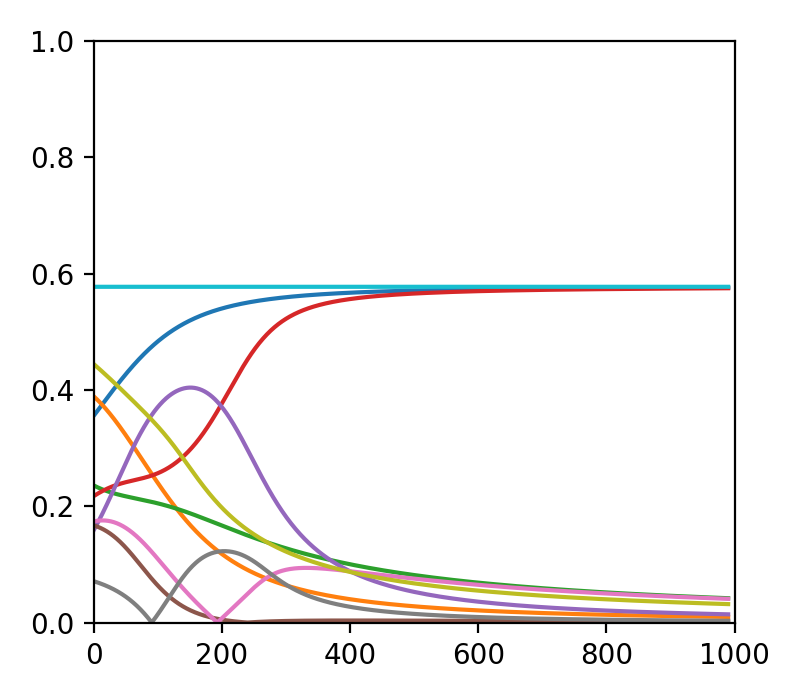

In [188]:
fig,ax = plt.subplots()
to_plot = label_d_to_edge_indices(0,10,0)
print(to_plot)
for i in range(to_plot[0],to_plot[3]):
    ax.plot(B/GAUSS,np.abs(COUPLINGS_SPARSE[i,:]))
    
ax.set_xlim(0,1000)
ax.set_ylim(0,1)

# All pairs best fidelity

In [229]:
@jit(nopython=True)
def twice_average_fidelity(k,g):
    k2 = k**2
    k4 = k2**2
    g2 = g**2
    g4 = g2**2
    g2p1 = 1+g2
    g2p12 = g2p1*g2p1
    g2p13 = g2p12*g2p1
    return (g2p12 + k2*(16*g2p1-24) + 16*k4)/(g2p13 + (-8 + 20*g2 + g4)*k2 + 16*k4)

In [226]:
@jit(nopython=True)
def twice_average_fidelity(k,g):
    # k2 = k**2
    # k4 = k2**2
    # g2 = g**2
    # g4 = g2**2
    # g2p1 = 1+g2
    # g2p12 = g2p1*g2p1
    # g2p13 = g2p12*g2p1
    if np.any(k):
        return 1-np.abs(g)**2/np.abs(k)**2
    else:
        return 0.5*np.ones(k.shape)

In [190]:
POLARISED_PAIR_FIDELITIES_UT = np.zeros((N_STATES,N_STATES,B_STEPS))
UNPOLARISED_PAIR_FIDELITIES_UT = np.zeros((N_STATES,N_STATES,B_STEPS))

for Na in range(N_MAX):
    Nb = Na+1
    lowera = PER_MN * (Na)**2
    uppera = lowera + PER_MN*(2*Na+1)
    upperb = uppera + PER_MN*(2*Nb+1)
    for i in range(lowera,uppera):
        li = LABELS_D[i,:]
        for j in range(uppera,upperb):
            lj = LABELS_D[j,:]
            P = (lj[1]-li[1])*(li[0]-lj[0])
            if P not in [-2,0,2]:
                continue
            P=int(P/2)

            couplings_polarised = [COUPLINGS_ZERO,COUPLINGS_PLUS,COUPLINGS_MINUS][P]

            ks_up = np.abs((ENERGIES[:, :] - ENERGIES[:, j, None]) * PULSE_TIME / scipy.constants.h)
            ks_down = np.abs((ENERGIES[:, :] - ENERGIES[:, i, None]) * PULSE_TIME / scipy.constants.h)

            gs_unpolarised_up = np.abs(COUPLINGS_UNPOLARISED[:, i, :]/COUPLINGS_UNPOLARISED[:, i, j, None])
            gs_polarised_up = np.abs(couplings_polarised[:, i, :]/couplings_polarised[:, i, j, None])

            gs_unpolarised_down = np.abs(COUPLINGS_UNPOLARISED[:, j, :]/COUPLINGS_UNPOLARISED[:, i, j, None])
            gs_polarised_down = np.abs(couplings_polarised[:, j, :]/couplings_polarised[:, i, j, None])

            fidelities_unpolarised_up = twice_average_fidelity(ks_up,gs_unpolarised_up)
            fidelities_unpolarised_down = twice_average_fidelity(ks_down,gs_unpolarised_down)

            fidelities_polarised_up = twice_average_fidelity(ks_up,gs_polarised_up)
            fidelities_polarised_down = twice_average_fidelity(ks_down,gs_polarised_down)

            fidelities_unpolarised_up[:,np.array([i,j])] = 1
            fidelities_unpolarised_down[:,np.array([i,j])] = 1
            fidelities_polarised_up[:,np.array([i,j])] = 1
            fidelities_polarised_down[:,np.array([i,j])] = 1

            UNPOLARISED_PAIR_FIDELITIES_UT[i,j,:] = np.prod(fidelities_unpolarised_up,axis=1) * np.prod(fidelities_unpolarised_down,axis=1)
            POLARISED_PAIR_FIDELITIES_UT[i,j,:] = np.prod(fidelities_polarised_up,axis=1) * np.prod(fidelities_polarised_down,axis=1)

NameError: name 'COUPLINGS_UNPOLARISED' is not defined

# Save to files

In [14]:
np.savez_compressed(f'../precomputed/{settings_string}.npz',
                    b = B,
                    energies = ENERGIES,
                    states = STATES, 
                    labels_d = LABELS_D,
                    uncoupled_labels_d = UNCOUPLED_LABELS_D,
                    magnetic_moments = MAGNETIC_MOMENTS, 
                    couplings_zero = COUPLINGS_ZERO,
                    couplings_minus = COUPLINGS_MINUS,
                    couplings_plus = COUPLINGS_PLUS,
                    unpolarised_pair_fidelities_ut = UNPOLARISED_PAIR_FIDELITIES_UT,
                    polarised_pair_fidelities_ut = POLARISED_PAIR_FIDELITIES_UT
                   )

# Form fidelity

In [209]:
def polarised_edge_to_fs(from_label,to_label,t_gate):
    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]

    up_node_indices = generated_edge_indices[from_neighbours[section_index]:from_neighbours[section_index+1],1]
    down_node_indices = generated_edge_indices[to_neighbours[section_index+3]:to_neighbours[section_index+4],1]
    
    ks_up   = np.abs((ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])*(t_gate[None,:])/(scipy.constants.h))
    ks_down = np.abs((ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])*(t_gate[None,:])/(scipy.constants.h))

    #from->to
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = COUPLINGS_SPARSE[from_neighbours[section_index]:from_neighbours[section_index+1],:]/specific_coupling
    gs_down = COUPLINGS_SPARSE[to_neighbours[section_index+3]:to_neighbours[section_index+4],:]/specific_coupling

    fs_up = twice_average_fidelity(ks_up,gs_up)
    fs_down = twice_average_fidelity(ks_down,gs_down)
    
    return fs_up,fs_down

In [210]:
def unpolarised_edge_to_fs(from_label,to_label,t_gate):
    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if  P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]

    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    ks_up   = np.abs((ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])*(t_gate[None,:])/(scipy.constants.h))
    ks_down = np.abs((ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])*(t_gate[None,:])/(scipy.constants.h))

    #from->to
    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)

    fs_up = twice_average_fidelity(ks_up,gs_up)
    fs_down = twice_average_fidelity(ks_down,gs_down)
    
    return fs_up,fs_down

In [230]:
fs_up, fs_down = unpolarised_edge_to_fs((1,12,0),(2,14,0), t_gate=500*1e-6*np.ones(B_STEPS))

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/3600358568.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


(0.0, 13.0)

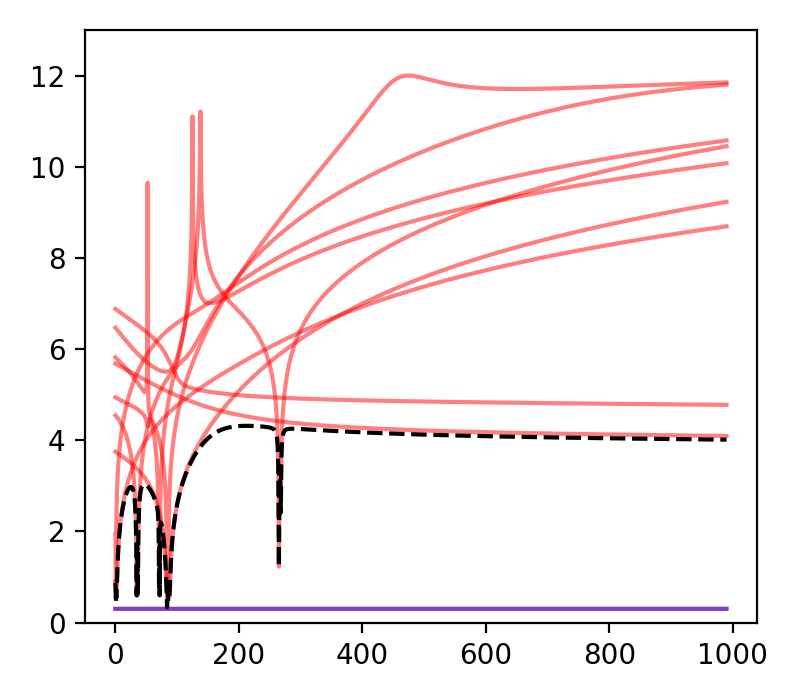

In [231]:
fig,ax=plt.subplots()
ax.plot(B/GAUSS,-np.log10(1-fs_up+1e-12).T,c='red',alpha=0.5)
ax.plot(B/GAUSS,-np.log10(1-fs_down+1e-12).T,c='blue',alpha=0.5)

fs_tot = np.prod(np.clip(fs_up,0.5,1),axis=0)*np.prod(np.clip(fs_down,0.5,1),axis=0)*4
ax.plot(B/GAUSS, -np.log10(1-fs_tot+1e-12),c='black',linestyle='dashed')

ax.set_ylim(0,13)
# plt.show()

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/836595492.py:94: RuntimeWarning: invalid value encountered in log10
  ax.plot(B/GAUSS,-np.log10(1-total_fid_opt*this_deviation_fid_opt),c='green',lw=1,alpha=0.7)
/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_2405/836595492.py:97: RuntimeWarning: invalid value encountered in log10
  ax.plot(B/GAUSS,-np.log10(1-total_fid_fixed*this_deviation_fid_fixed),c='red',lw=1,alpha=0.7)


(0.0, 4000.0)

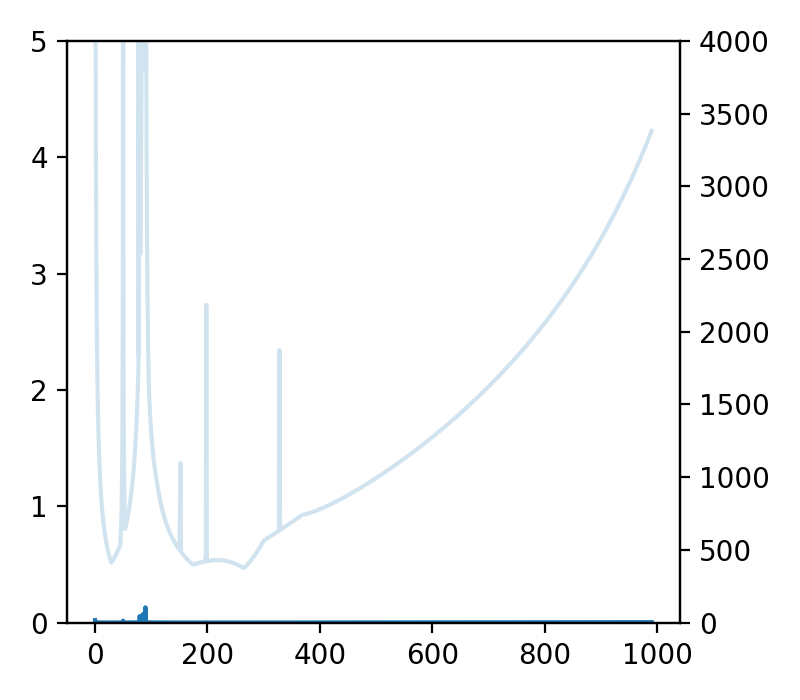

In [196]:
states = [(1,8,3),(0,8,1),(1,6,2)]
desired_indices = [label_d_to_node_index(*label) for label in states]
B_NOISE = 35 * 1e-3 * GAUSS
T_OLD = 500*1e-6

# Find best B for minimum dipole deviation
all_moments = MAGNETIC_MOMENTS[:,desired_indices]
this_deviation = np.abs((np.amax(all_moments,axis=1) - np.amin(all_moments,axis=1)))

# required_deviation = all_moments[:,0]-all_moments[:,2]
# sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
# mask = np.ones(max_bi, dtype=bool)
# mask[sign_changes] = False
# mask[sign_changes+1] = False
# this_rating[mask] = 0

# Find best times
t_opt_global_max = np.zeros(B_STEPS, dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label

    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]
    
    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    deltas_up   = np.abs(ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])/H_BAR
    deltas_down = np.abs(ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])/H_BAR
    
    mask_up = up_node_indices == to_node_index
    mask_down = down_node_indices == from_node_index
    
    deltas_up[mask_up,:] = 1e9*np.ones(B_STEPS)
    deltas_down[mask_down,:] = 1e9*np.ones(B_STEPS)

    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)
    
    t_opt_up = ((4 * np.pi**2 * gs_up[:,:] ** 2 * scipy.constants.h)/(deltas_up[:,:]**2 * this_deviation[None,:] * B_NOISE))**(1/3)
    t_opt_max_up = np.max(t_opt_up, axis=0)
    t_opt_down = ((4 * np.pi**2 * gs_down[:,:] ** 2 * scipy.constants.h)/(deltas_down[:,:]**2 * this_deviation[None,:] * B_NOISE))**(1/3)
    t_opt_max_down = np.max(t_opt_down, axis=0)
    t_opt_max = np.maximum(t_opt_max_up,t_opt_max_down)
    
    t_opt_global_max = np.maximum(t_opt_max,t_opt_global_max)
    

this_deviation_fid_fixed = np.exp(-T_OLD*this_deviation*B_NOISE/(scipy.constants.h))
this_deviation_fid_opt = np.exp(-t_opt_global_max*this_deviation*B_NOISE/(scipy.constants.h))

fig,ax = plt.subplots()

# Simulate microwave transfers to find fidelity *within structure*
total_fid_fixed = np.ones(B_STEPS,dtype=np.double)
total_fid_opt = np.ones(B_STEPS,dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label
        
    fs_up_fixed, fs_down_fixed = unpolarised_edge_to_fs(from_label, to_label, t_gate=T_OLD*np.ones(B_STEPS))
    total_fid_fixed *= np.prod(fs_up_fixed,axis=0)
    total_fid_fixed *= np.prod(fs_down_fixed,axis=0)
    total_fid_fixed *= 4
    
    
    fs_up_opt, fs_down_opt = unpolarised_edge_to_fs(from_label, to_label, t_gate=t_opt_global_max)
    total_fid_opt *= np.prod(fs_up_opt,axis=0)
    total_fid_opt *= np.prod(fs_down_opt,axis=0)
    total_fid_opt *= 4
    # ax.plot(B/GAUSS,-np.log10(1-fs_down_opt.T))
    # ax.plot(B/GAUSS,-np.log10(1-fs_up_opt.T))

    


ax.plot(B/GAUSS,t_opt_global_max)
ax.plot(B/GAUSS,-np.log10(1-total_fid_opt*this_deviation_fid_opt),c='green',lw=1,alpha=0.7)
# ax.plot(B/GAUSS,-np.log10(1-total_fid_opt),c='orange',lw=1,alpha=0.7)
# ax.plot(B/GAUSS,-np.log10(1-this_deviation_fid_opt),c='cyan',lw=1,alpha=0.7)
ax.plot(B/GAUSS,-np.log10(1-total_fid_fixed*this_deviation_fid_fixed),c='red',lw=1,alpha=0.7)

ax2 = ax.twinx()
ax2.plot(B/GAUSS,t_opt_global_max*1e6,alpha=0.2)

ax.set_ylim(0,5)
ax2.set_ylim(0,4000)

# Optimise for t_gate and delta_b

In [198]:
# %%timeit

states = [(0,8,1),(1,8,0),(0,8,0)]
desired_indices = [label_d_to_node_index(*label) for label in states]

# Find best B for minimum dipole deviation
all_moments = MAGNETIC_MOMENTS[:,desired_indices]
this_deviation = np.abs((np.amax(all_moments,axis=1) - np.amin(all_moments,axis=1)))

DESIRED_FIDELITY = 0.999

# required_deviation = all_moments[:,0]-all_moments[:,2]
# sign_changes = np.where(np.diff(np.sign(required_deviation)))[0]
# mask = np.ones(max_bi, dtype=bool)
# mask[sign_changes] = False
# mask[sign_changes+1] = False
# this_rating[mask] = 0

# Find best times
t_required_global_max_unpol = np.zeros(B_STEPS, dtype=np.double)
t_required_global_max_pol = np.zeros(B_STEPS, dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label

    P=(from_label[0]-to_label[0])*(to_label[1]-from_label[1])
    if P == 0:
        section_index = 0
    elif P == 2:
        section_index = 1
    elif P == -2:
        section_index = 2
    
    from_node_index = label_d_to_node_index(*from_label)
    to_node_index = label_d_to_node_index(*to_label)

    from_neighbours = label_d_to_edge_indices(*from_label)
    to_neighbours = label_d_to_edge_indices(*to_label)

    specific_up_index = from_neighbours[section_index]+to_label[2]
    
    up_node_indices = generated_edge_indices[from_neighbours[0]:from_neighbours[3],1]
    down_node_indices = generated_edge_indices[to_neighbours[3]:to_neighbours[6],1]
    
    deltas_up   = np.abs(ENERGIES[up_node_indices,:] - ENERGIES[to_node_index,:])/H_BAR
    deltas_down = np.abs(ENERGIES[down_node_indices,:] - ENERGIES[from_node_index,:])/H_BAR
    
    mask_up = up_node_indices == to_node_index
    mask_down = down_node_indices == from_node_index
    
    deltas_up[mask_up,:] = 1e9*np.ones(B_STEPS)
    deltas_down[mask_down,:] = 1e9*np.ones(B_STEPS)

    specific_coupling = COUPLINGS_SPARSE[specific_up_index,:]

    gs_up = np.abs(COUPLINGS_SPARSE[from_neighbours[0]:from_neighbours[3],:]/specific_coupling)
    gs_down = np.abs(COUPLINGS_SPARSE[to_neighbours[3]:to_neighbours[6],:]/specific_coupling)
    
    ###
    t_required_up_unpol = (2*gs_up*np.pi)/(deltas_up)    
    t_required_down_unpol = (2*gs_down*np.pi)/(deltas_down)
    t_required_max_up_unpol = np.max(t_required_up_unpol, axis=0, initial=0)
    t_required_max_down_unpol = np.max(t_required_down_unpol, axis=0, initial=0)
    t_required_max_unpol = np.maximum(t_required_max_up_unpol,t_required_max_down_unpol)
    t_required_global_max_unpol = np.maximum(t_required_max_unpol,t_required_global_max_unpol)
    
    start_index_from = from_neighbours[0]
    start_index_to = to_neighbours[0]
    t_required_up_pol = t_required_up_unpol[from_neighbours[section_index]-start_index_from:from_neighbours[section_index+1]-start_index_from,:]
    t_required_down_pol = t_required_down_unpol[to_neighbours[section_index+3]-start_index_to:to_neighbours[section_index+4]-start_index_to,:]
    t_required_max_up_pol = np.max(t_required_up_pol, axis=0, initial=0)    
    t_required_max_down_pol = np.max(t_required_down_pol, axis=0, initial=0)
    t_required_max_pol = np.maximum(t_required_max_up_pol,t_required_max_down_pol)
    t_required_global_max_pol = np.maximum(t_required_max_pol,t_required_global_max_pol)
    
delta_b_required_unpol = (scipy.constants.h) / (this_deviation * t_required_global_max_unpol)
delta_b_required_pol = (scipy.constants.h) / (this_deviation * t_required_global_max_pol)

0 = 0
37.76us unpolarised
37.76us polarised
27275.18mG
----
1 = 0.9
119.40us unpolarised
119.40us polarised
862.52mG
----
2 = 0.99
377.58us unpolarised
377.58us polarised
27.28mG
----
3 = 0.999
1194.01us unpolarised
1194.01us polarised
0.86mG
----
4 = 0.9999
3775.80us unpolarised
3775.80us polarised
0.03mG
----


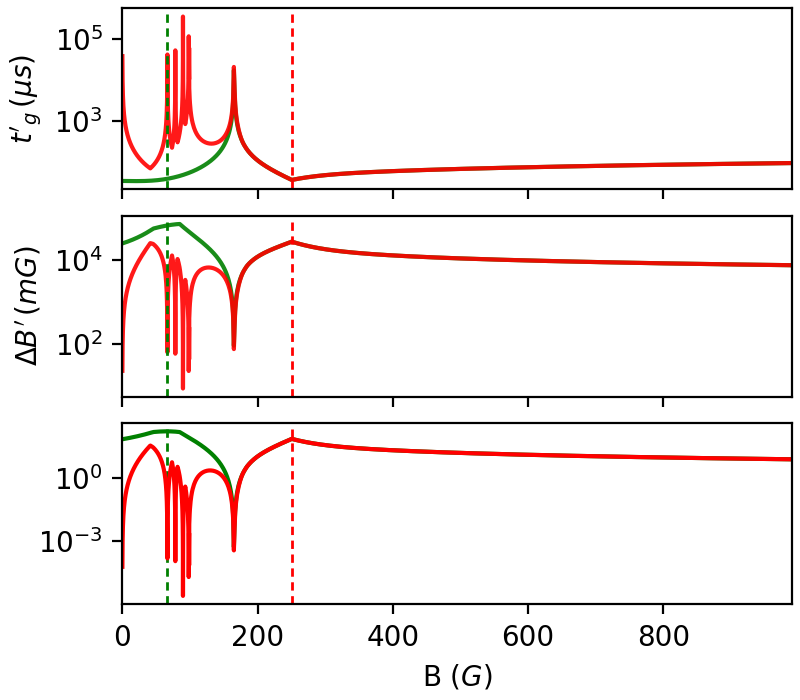

In [233]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,constrained_layout=True)
ax1.set_xlim(0,B_MAX/GAUSS)

# Simulate microwave transfers to find fidelity *within structure*
total_fid_opt = np.ones(B_STEPS,dtype=np.double)
for from_label, to_label in zip(states, states[1:]):
    if from_label[0]>to_label[0]:
        from_label,to_label = to_label,from_label
    
    fs_up_opt, fs_down_opt = unpolarised_edge_to_fs(from_label, to_label, t_gate=t_required_global_max_unpol)
    total_fid_opt *= np.prod(fs_up_opt,axis=0)
    total_fid_opt *= np.prod(fs_down_opt,axis=0)
    total_fid_opt *= 4

MAX_TIME_US = 2000
X=B/GAUSS

Y=t_required_global_max_pol*1e6
ax1.plot(X,Y,alpha=0.9,c='green') # us
# ax.fill_between(X, Y, MAX_TIME_US, color= "green", alpha= 0.3)

Y=t_required_global_max_unpol*1e6
ax1.plot(X,Y,alpha=0.9,c='red') # us
ax1.set_yscale('log', base=10)
# ax.fill_between(X, Y, MAX_TIME_US, color= "red", alpha= 0.3)

Y = delta_b_required_pol*1e4*1e3
ax2.plot(X,Y,alpha=0.9,c='green') # uG
ax2.set_yscale('log', base=10)

Y = delta_b_required_unpol*1e4*1e3
ax2.plot(X,Y,alpha=0.9,c='red') # uG
ax2.set_yscale('log', base=10)

Y = delta_b_required_pol/(t_required_global_max_pol)
Y_max_arg = np.argmax(Y)
ax3.plot(X,Y,color='green')
ax3.set_yscale('log', base=10)
# ax3.set_title(f"{X[Y_max_arg]:.1f}G")
for ax in (ax1,ax2,ax3):
    ax.axvline(X[Y_max_arg],color='green',linewidth=1,dashes=(3,2))
    
Y = delta_b_required_unpol/(t_required_global_max_unpol)
Y_max_arg = np.argmax(Y)
ax3.plot(X,Y,color='red')
ax3.set_yscale('log', base=10)
# ax3.set_title(f"{X[Y_max_arg]:.1f}G")
for ax in (ax1,ax2,ax3):
    ax.axvline(X[Y_max_arg],color='red',linewidth=1,dashes=(3,2))

ax1.set_ylabel("$t'_{g}\, (\mu s)$")
ax2.set_ylabel("$\Delta B'\, (m G)$")
ax3.set_xlabel("B $(G)$")

t_g_unpol = t_required_global_max_unpol[Y_max_arg] #* (1-d_f)**(-1/2)
t_g_pol = t_required_global_max_pol[Y_max_arg] #* (1-d_f)**(-1/2)
d_b_g = delta_b_required_unpol[Y_max_arg] #* (1-d_f)**(3/2)

for d in range(0,5):
    print(d, "=", 1-10**(-d))
    print(f"{t_g_unpol * 10**(d/2) * 1e6:.2f}us unpolarised")
    print(f"{t_g_pol * 10**(d/2) * 1e6:.2f}us polarised")
    print(f"{d_b_g * 10**(-3*d/2) *1e4*1e3:.2f}mG")
    print("----")

# ax.set_title("0.999 Fidelity")

# How to load file
Copy 'Defining Parameters' and 'Computed Constants' section, then load the file from computed `settings_string`.

In [15]:
data = np.load(f'../precomputed/{settings_string}.npz')
energies_loaded = data['energies']
print(energies_loaded.shape)

(1449, 288)
